In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
from sklearn import mixture

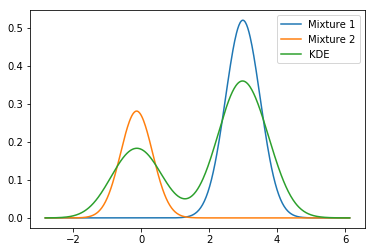

In [2]:
#fit mixture model
obs = np.concatenate((np.random.normal(loc=0.0, scale=0.5, size=100), np.random.normal(loc=3.0, scale=.5, size=200)))
g = mixture.GaussianMixture(n_components=2)
g.fit(obs.reshape(300,1))

#do kernel estimation
dens = sm.nonparametric.KDEUnivariate(obs)
dens.fit()

#draw mixture model
comp1 = g.weights_[0]*stats.norm.pdf(dens.support,g.means_[0,0],g.covariances_[0,0]**.5)
comp2 = g.weights_[1]*stats.norm.pdf(dens.support,g.means_[1,0],g.covariances_[1,0]**.5)

plt.plot(dens.support, comp1, label='Mixture 1')
plt.plot(dens.support, comp2, label='Mixture 2')
plt.plot(dens.support, dens.density, label='KDE')
plt.legend()
plt.show()

In [13]:
#variables names
lmilk = ['LSCORE']
auct_key = ['YEAR','MONTH','DAY','SYSTEM','FMOZONE']
lcts = ['LFMO','LGAS','LPOPUL','LQSCORE']#,'LMEALS']
dummies = ['COOLER','ESC', 'NUM']
fekeys = ['3','6','7','9']


bid_key = auct_key + ['VENDOR'] + ['COUNTY']
covariates = lcts + dummies + fekeys

data = pd.read_csv('data/clean_milk0.csv')
data = data.copy()[bid_key + lmilk + covariates + ['WIN']]
data = data.dropna()

No handles with labels found to put in legend.


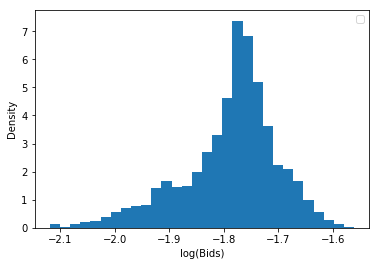

In [14]:
#load data
bids = np.array(data['LSCORE'])

#log transformation/ ignore outlier for the plot
bids = bids[ (.12<=np.exp(bids)) & (np.exp(bids)<=.21) ]

#do kernel density estimation
dens = sm.nonparametric.KDEUnivariate(bids)
dens.fit()

#plt.plot(dens.support, dens.density, label='KDE')
plt.hist(bids, 30,density=True)
plt.xlabel('log(Bids)')
plt.ylabel('Density')
plt.legend()
plt.savefig('results/bids_density.png')
plt.show()

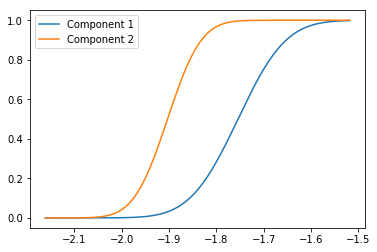

In [15]:
#fit mixture model
g = mixture.GaussianMixture(n_components=2)
g.fit(bids.reshape(bids.shape[0],1))

#first see stocahstic dominance
comp1_cdf = stats.norm.cdf(dens.support,g.means_[0,0],g.covariances_[1,0]**.5)
comp2_cdf = stats.norm.cdf(dens.support,g.means_[1,0],g.covariances_[0,0]**.5)

plt.plot(dens.support, comp1_cdf, label='Component 1')
plt.plot(dens.support, comp2_cdf, label='Component 2')
plt.legend()
plt.show()

In [16]:
#create a table?

print(np.exp(g.means_[0,0]), np.exp(g.means_[1,0]))
print( 'Means: %s'%g.means_[:,0])
print( 'exp Means: %s'%np.exp(g.means_[:,0]))
print( 'Var: %s'%g.covariances_[:,0,0]**.5)
print( 'Weights: %s'%g.weights_)

0.173014799431773 0.1490936749993921
Means: [-1.75437814 -1.90318048]
exp Means: [0.1730148  0.14909367]
Var: [0.05597777 0.07961514]
Weights: [0.76937445 0.23062555]


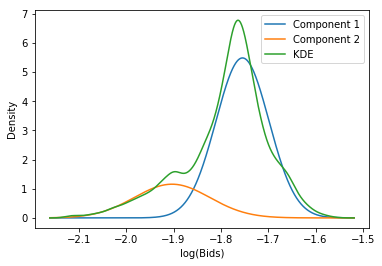

In [17]:
#graph kernel with mixture components
comp1 = g.weights_[0]*stats.norm.pdf(dens.support,g.means_[0,0],g.covariances_[0,0]**.5)
comp2 = g.weights_[1]*stats.norm.pdf(dens.support,g.means_[1,0],g.covariances_[1,0]**.5)

plt.plot(dens.support, comp1, label='Component 1')
plt.plot(dens.support, comp2, label='Component 2')
plt.xlabel('log(Bids)')
plt.ylabel('Density')
plt.plot(dens.support, dens.density, label='KDE')
plt.legend()
plt.savefig('results/bid_mixture.png')
plt.show()

In [18]:
wbids = data[data['WIN']==1]
wbids = np.array(wbids['LSCORE'])
wbids = wbids[ (.12<=np.exp(wbids)) & (np.exp(wbids)<=.21) ]
g = mixture.GaussianMixture(n_components=2)
g.fit(wbids.reshape(wbids.shape[0],1))

print( 'Means: %s'%g.means_[:,0])
print( 'Means: %s'%np.exp(g.means_[:,0]))
print( 'Var: %s'%(g.covariances_[:,0,0])**.5)
print( 'Weights: %s'%g.weights_)

Means: [-1.7836326  -1.92995194]
Means: [0.16802666 0.14515517]
Var: [0.04054941 0.06543758]
Weights: [0.73518388 0.26481612]


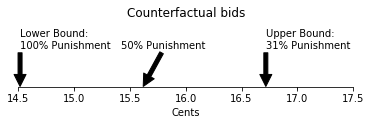

In [19]:
ax = plt.subplot(3,1,1)

ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.set_xlim(14.5, 17.5)
ax.set_ylim(0, 5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.title('Counterfactual bids')
plt.xlabel('Cents')

lb =np.exp(g.means_[1,0])*100
ub = np.exp(bids.mean())*100
mid = np.exp(.5*g.means_[0,0] + .5*g.means_[1,0])*100

ax.annotate('Lower Bound:\n100% Punishment', xy=(lb,0), xytext=(lb,3), 
            arrowprops=dict(facecolor='black', shrink=0.01) )

ax.annotate('Upper Bound:\n31% Punishment', xy=(ub,0), xytext=(ub,3), 
            arrowprops=dict(facecolor='black', shrink=0.01) )

ax.annotate('50% Punishment', xy=(mid,0), xytext=(mid-.2,3), 
            arrowprops=dict(facecolor='black', shrink=0.01) )

#plt.savefig('results/cf_analysis.png', bbox_inches = 'tight')
plt.show()

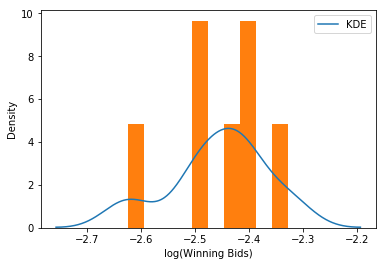

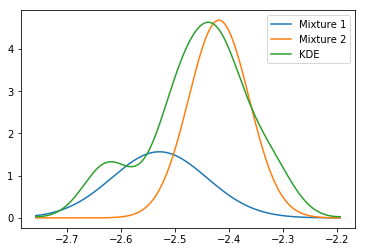

In [20]:
data  = pd.read_csv('data/milk.csv')
wbids = data['SCORE'][data['WIN']==1]
lwbids = np.array(np.log(wbids[ (wbids<=.1) & (wbids<=.21) ]))


dens = sm.nonparametric.KDEUnivariate(lwbids)
dens.fit()

plt.plot(dens.support, dens.density, label='KDE')
plt.hist(lwbids,10,density=True)
plt.xlabel('log(Winning Bids)')
plt.ylabel('Density')
plt.legend()
plt.show()

g = mixture.GaussianMixture(n_components=2)
g.fit(lwbids.reshape(lwbids.shape[0],1))

#print 'Means: %s'%g.means_[:,0]
#print 'Var: %s'%g.covariances_[:,0,0]
#print 'Weights: %s'%g.weights_

#first see stocahstic dominance
comp1 = g.weights_[0]*stats.norm.pdf(dens.support,g.means_[0,0],g.covariances_[0,0]**.5)
comp2 = g.weights_[1]*stats.norm.pdf(dens.support,g.means_[1,0],g.covariances_[1,0]**.5)

plt.plot(dens.support, comp1, label='Mixture 1')
plt.plot(dens.support, comp2, label='Mixture 2')
plt.plot(dens.support, dens.density, label='KDE')
plt.legend()
plt.show()

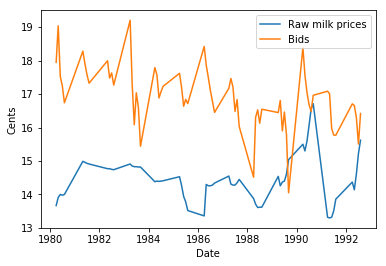

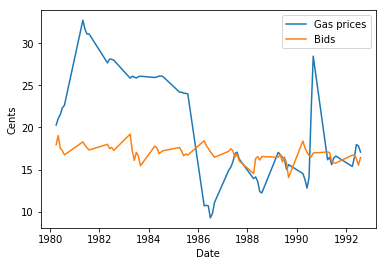

In [31]:
#summary statistics
rawdata = pd.read_csv('data/milk.csv')
data= rawdata.copy()

#general house keeping
data = data[ (data['YEAR']>=1980)]
data = data[(data['MONTH'] >= 4) & (data['MONTH'] <= 9) & (data['DAY'] !=0) ] #need data with time index
data = data[(~np.isnan(data['SCORE']) ) & (data['QSCORE']!=0 )] #need data with QWW and WW

plot_points = data.groupby(['YEAR','MONTH'],as_index=False).mean()
labels = plot_points['MONTH'].astype(str) + '/'+ plot_points['YEAR'].astype(str)
labels = pd.to_datetime(labels,infer_datetime_format=True)

plt.plot(labels,plot_points['FMO'], label='Raw milk prices')
plt.plot(labels,plot_points['SCORE']*100, label='Bids')
plt.xlabel('Date')
plt.ylabel('Cents')
plt.legend()
plt.savefig('results/milk_vs_time1.png')

plt.show()


plt.plot(labels,plot_points['GAS'], label='Gas prices')
plt.plot(labels,plot_points['SCORE']*100, label='Bids')
plt.xlabel('Date')
plt.ylabel('Cents')
plt.legend()
plt.savefig('results/milk_vs_time2.png')

plt.show()

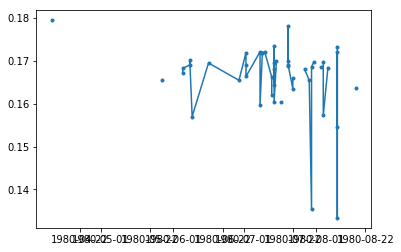

In [22]:
auct_key = ['YEAR','MONTH','DAY','SYSTEM','FMOZONE']
min_lag = data.groupby(auct_key, as_index=False).min()
cool_thing = min_lag[min_lag['YEAR']==1980]

labels = (cool_thing['MONTH'].astype(str) + '/'+
          cool_thing['DAY'].astype(str) + '/' + cool_thing['YEAR'].astype(str))
labels = pd.to_datetime(labels,infer_datetime_format=True)

plt.plot(labels, cool_thing['SCORE'],marker='.')

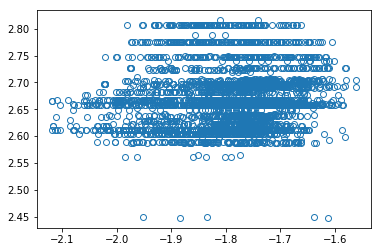

In [23]:
data = pd.read_csv('data/milk.csv')

reg1 = data[['SCORE','FMO']].dropna()
reg1 = np.log(reg1[(.12<=reg1['SCORE']) & (reg1['SCORE']<=.21)])
plt.plot(reg1['SCORE'],reg1['FMO'],'o',mfc='none')